In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %pip install -r ../requirements.txt

In [3]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

Importing plotly failed. Interactive plots will not work.


In [4]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [5]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [6]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2017',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon', 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [7]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    # ft.AirQualityFeatures,
    # ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    # ft.GoogleTrendFeatures,
    # ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.SportsCompetitionFeatures,
    # ft.TrafficFeatures
    ]

In [8]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [9]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [10]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [11]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13e02d1e0>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13e02f700>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13e02fe20>)],
                  verbose=True)

In [12]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [13]:
features_config_get = {}

In [14]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'], #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard'],
    'axis': 'columns',
    'shift': range(1, 7, 1),
    'rolling_window': [14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(7, 14, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr':0.65,
    'data_dir': root_dir / 'data',
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    'target_bins': [0, 0.97, 1.0],
    'replace_target': False
    }

In [15]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-08 14:32:24,753: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-08 14:32:24,764: INFO: Initialisation des features
root 2024-11-08 14:32:24,767: INFO: Fetching data for hospitalfeatures at CHU Dijon
root 2024-11-08 14:32:25,008: INFO: Fetching data for hospitalfeatures at CHU Besançon
root 2024-11-08 14:32:25,159: INFO: Fetching data for hospitalfeatures at CH Beaune
root 2024-11-08 14:32:25,328: INFO: Fetching data for hospitalfeatures at CH Semur
root 2024-11-08 14:32:25,492: INFO: Fetching data for hospitalfeatures at CH Chatillon Montbard
root 2024-11-08 14:32:25,666: INFO: Fetching data for hospitalfeatures at CH Chaumont
root 2024-11-08 14:32:25,836: INFO: Fetching data for hospitalfeatures at CH Langres
root 2024-11-08 14:32:26,009: INFO: Fetching data for hospitalfeatures at HNFC
root 2024-11-08 14:32:26,160: INFO: Fetching data for sociologicalfeatures at CHU Dijon
root 2024-11-08 14:32:26,314: INFO: Fetching data for sociologicalfeatures at CHU

Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped 0 constant columns from both sets: []
X shape: (1162, 99), y shape: (1162, 1)
            target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J
date                                                      
2019-01-03                                      189.666667
2019-01-04                                      192.666667
2019-01-05                                      195.333333
2019-01-06                                      199.000000
2019-01-07                                      199.333333
...                                                    ...
2022-03-05                                      201.000000
2022-03-06                                      210.000000
2022-03-07                                      203.000000
2022-03-08                                      200.000000
2022-03-09                                      197.666667

[1162 rows x 1 columns]
[ColumnTransformer] .... (1 of 3) Processing

In [16]:
arsTabularDataset.targets_names

['target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J']

In [17]:
df = arsTabularDataset.data

In [18]:
df

,nb_emmergencies_CHU Dijon,nb_emmergencies%%J-1_CHU Dijon,nb_emmergencies%%J-2_CHU Dijon,nb_emmergencies%%J-3_CHU Dijon,nb_emmergencies%%J-4_CHU Dijon,nb_emmergencies%%J-5_CHU Dijon,nb_emmergencies%%J-6_CHU Dijon,nb_emmergencies%%mean_14J_CHU Dijon,nb_emmergencies%%std_14J_CHU Dijon,nb_emmergencies%%mean_31J_CHU Dijon,...,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-13,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J_category
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,186,198.0,202.0,200.0,186.0,238.0,202.0,202.428571,19.202221,198.419355,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,1.0
2019-01-04,186,186.0,198.0,202.0,200.0,186.0,238.0,202.571429,19.061497,197.741935,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,1.0
2019-01-05,204,186.0,186.0,198.0,202.0,200.0,186.0,203.500000,17.783960,197.967742,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,1.0
2019-01-06,182,204.0,186.0,186.0,198.0,202.0,200.0,201.142857,14.965895,199.129032,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,1.0
2019-01-07,194,182.0,204.0,186.0,186.0,198.0,202.0,198.428571,14.726816,199.322581,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,183,185.0,165.0,148.0,193.0,164.0,191.0,180.000000,15.908392,179.548387,...,188.000000,175.095238,7.910879,179.690476,10.341572,179.655914,9.812118,176.619178,13.992984,1.0
2023-12-21,187,183.0,185.0,165.0,148.0,193.0,164.0,180.714286,15.794004,179.612903,...,187.000000,174.809524,7.430810,180.952381,9.780372,179.408602,9.566806,176.581735,13.952051,1.0
2023-12-22,182,187.0,183.0,185.0,165.0,148.0,193.0,182.142857,15.356568,179.064516,...,175.333333,176.047619,8.213423,181.785714,9.481973,179.569892,9.601772,176.543379,13.912195,1.0


In [19]:
target_col = arsTabularDataset.targets_names[0]
category_col = f'{target_col}_category'


matplotlib.category 2024-11-08 14:32:28,774: INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

matplotlib.category 2024-11-08 14:32:28,784: INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


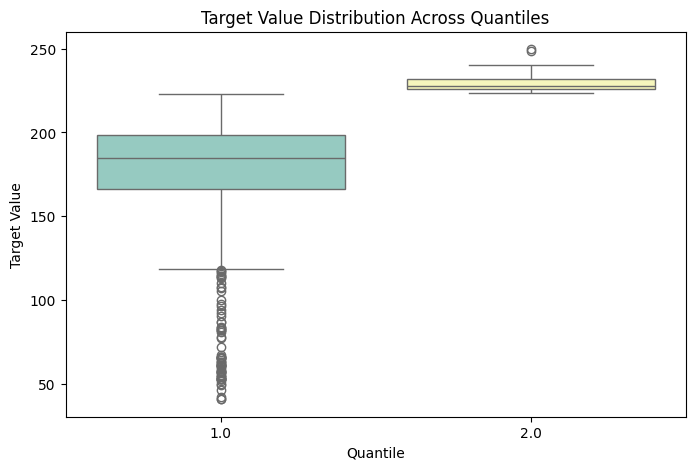

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=category_col, y=target_col, data=df, palette='Set3')
plt.xlabel('Quantile')
plt.ylabel('Target Value')
plt.title('Target Value Distribution Across Quantiles')
plt.show()


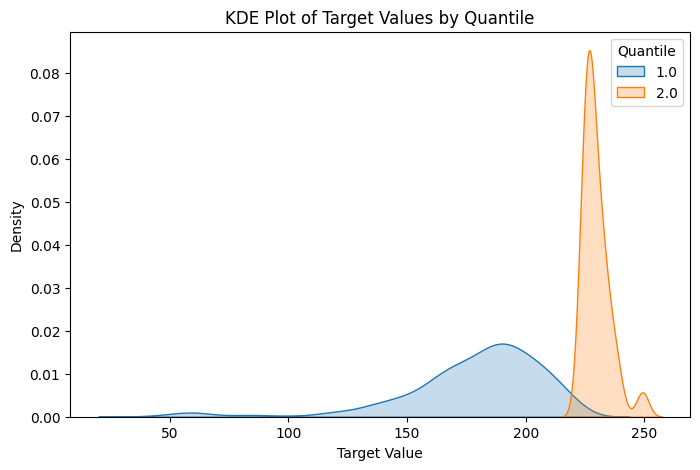

In [21]:
plt.figure(figsize=(8, 5))
for quantile in df[category_col].unique():
    sns.kdeplot(df[df[category_col] == quantile][target_col], label=f'{quantile}', fill=True)
plt.xlabel('Target Value')
plt.title('KDE Plot of Target Values by Quantile')
plt.legend(title='Quantile')
plt.show()


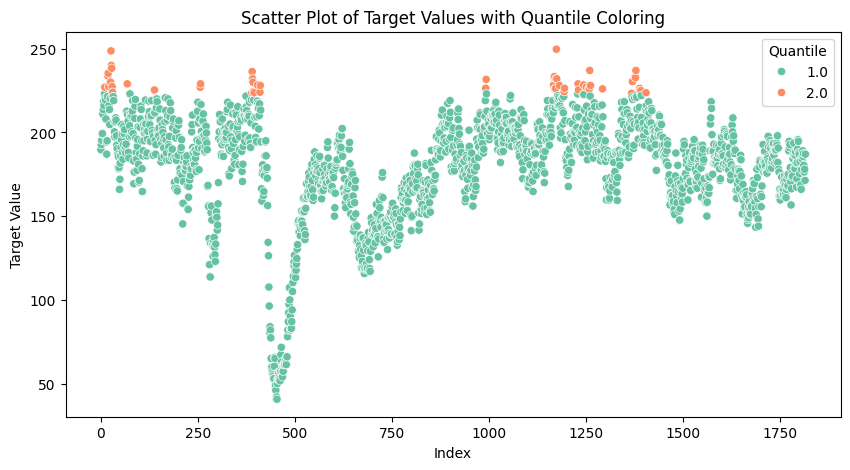

In [22]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(df)), y=target_col, hue=category_col, data=df, palette='Set2')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Scatter Plot of Target Values with Quantile Coloring')
plt.legend(title='Quantile')
plt.show()
